# SoComp EX1 -- Random Graph Models
#### Due date: Sunday May 28th, 23:59

# Part 1: The Copying Model

1. Produce a random graph according to the copying model with 100,000 vertices, probability 0.8 of copying links, and a out-going degree d=10.
2. Compute the in-degree of each vertex.
3. Compute the number of vertices with each in-degree.
4. Plot the number of vertices with each in-degree in a log-log plot (the x axis should be the degree, and the y axis the number of vertices in the graph with this in degree). 
5. Answer the following question: Did we get a power law? if so, what is the exponent? (write code to evaluate!)

### Reminder regarding the copying model: 
- Initialize the graph with d+1 vertices in a clique (each vertex has outgoing degree 10)
- Vertices are added one by one. 
- Each vertex $v$ chooses a model vertex $u$ uniformly at random (from vertices that were added before $v$). The vertices $v$ will connect to with its $d$ outgoing edges are either copied from $u$'s outgoing edges, or selected uniformly at random
  (iterate over all of $u$'s outgoing edges. With probability p=0.8 the edge is copied, otherwise, the target vertex is selected uniformly at random from vertices that were inserted to the graph prior to $v$). 
  
### Notes and comments:
- The representation of the random graph is up to you.
- Write nice, clean, understandable, well documented code.
- Embed the results in this notebook.

The exponent fit: -1.9565368193
The intercept fit: 0.850933210386


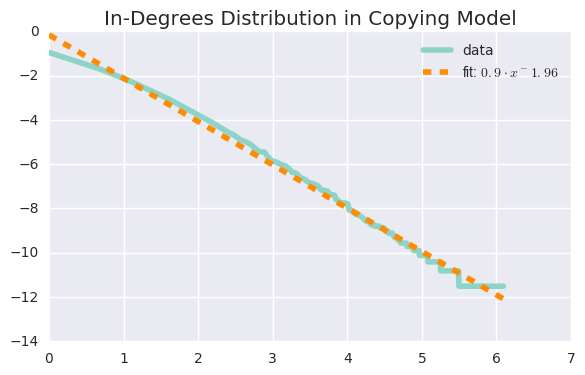

In [55]:
%matplotlib inline
import random
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import powerlaw
import numpy as np

plt.style.use("seaborn-darkgrid")
random.seed(0)            # for reproducibility
NUM_NEW_NODES = 100000    # number of new nodes to add
p = 0.8                   # probability parameter for copying (p) or sampling (1-p)
d = 10                    # intial out degree

# graph will be represented as a dict with keys as nodes and values a set of key's neighbours.
graph = {x: set(range(d)).difference({x}) for x in range(d)}   # initial clique
in_degree_counter = {x: d - 1 for x in range(d)}    # keeps the in-degree of every node in graph

for new_node in range(d, NUM_NEW_NODES):
    new_neighbors = set()
    prototype = random.choice(list(graph.keys()))  # choose prototype uniformaly
    for neighbour in graph[prototype]:
        if random.random() < p:         # imitates Bernoulli sampling
            new_neighbour = neighbour    # copy
        else:
            new_neighbour = random.choice(list(graph.keys()))   # sample a new neighbor
            
        new_neighbors.add(new_neighbour)
        in_degree_counter[new_neighbour] += 1
    
    graph[new_node] = new_neighbors          # update the graph with the link new_node -> neighbours
    in_degree_counter[new_node] = 0          # the new node that was just added has an in-degree of 0
    
# extract the counts:
in_degree_hist = Counter(in_degree_counter.values()).most_common()  # create a sorted histogram
degrees, counts = map(np.asarray, zip(*in_degree_hist))

# fit a power law: done by fitting a linear model on the log transformed data.
counts = counts / counts.sum()
rank = np.arange(counts.size)
coef = np.polyfit(x=np.log(rank + 1), y=np.log(counts), deg=1)
poly = np.poly1d(coef)

# plot:
# plt.loglog(counts)
print("The exponent fit:", poly.coeffs[0])
print("The intercept fit:", np.exp(poly.coeffs[1]))
plt.plot(np.log(rank+1), np.log(counts), label="data")
plt.plot(np.log(rank+1), poly(np.log(rank+1)), 
         label=r"fit: ${intercept:} \cdot x^{exp}$".format(intercept=round(np.exp(poly.coeffs[1]), 1), 
                                                           exp=round(poly.coeffs[0], 2)),
         linestyle="--", color="darkorange")
plt.legend()
plt.title("In-Degrees Distribution in Copying Model")


As can be seen, the above empirical distribution does follow Power Law fit nicely. Though it does seems like a bi-linear model would fit more elegantly, the current fit has a pretty decent $R^2$ score.

# Part 2: Six Degrees 1D version

For each value of $r \in \{ 0, 0.1, ... ,1.9, 2.0 \}$ repeat the following experiment 100 times, 
1. Produce a graph according to Kleinberg's small world model in 1D with wrap around with n=10,000 vertices and parameter $r$.
2. Find the shortest path length between vertex 0 and vertex n/2.
3. Find the greedy routing path length between these vertices.

- Produce a plot of the average shortest-path length found (over the 100 repetitions) for each value of $r$ (the x-axis is $r$, and the y-axis is the average path length.
- Produce a similar plot for the greedy-routing path length.
- Answer the following question: Which value of $r$ gave the shortest average path? which one gave the shortest greedy routing path?

### Kleinberg's model in 1D with wrap-around:
- Assume vertices 0,1,2,...,n-1 are placed on a circle.
- Vertex $i$ has outgoing edges to vertices $i+1, i-1$ (mod n).
- Define the 1D-distance between vertices $i$ and $j$: $dist_{1D}(i,j) = \min(|i-j|, n-|i-j|)$
- Add a single ougoing edge from each vertex $i$ to a destination vertex $j$ that is selected with probability distribution: 
$$Pr(j) = \frac{dist_{1D}(i,j)^{-r}}{\sum_{j'\neq i} dist_{1D}(i,j')^{-r} }$$
- The greedy routing algorithm starts at the source vertex and at each step chooses the edge that goes to the vertex that is closest to the destination (where closesness is defined according to dist_{1D}) 

### A note regarding running time:
Use the fact that the graph has wrap-around to save time when generating the long-range links.
If you are naive, the generation of links for the graph takes $O(n^2)$. More careful work can reduce this to $O(n)$.
Hint: You can compute the distribution of long-range links only once (per r-value). Beacuse of symmetry of the vertices, this distribution is the same (only shifted) for each vertex in the graph.

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:28: RuntimeWarning: divide by zero encountered in power


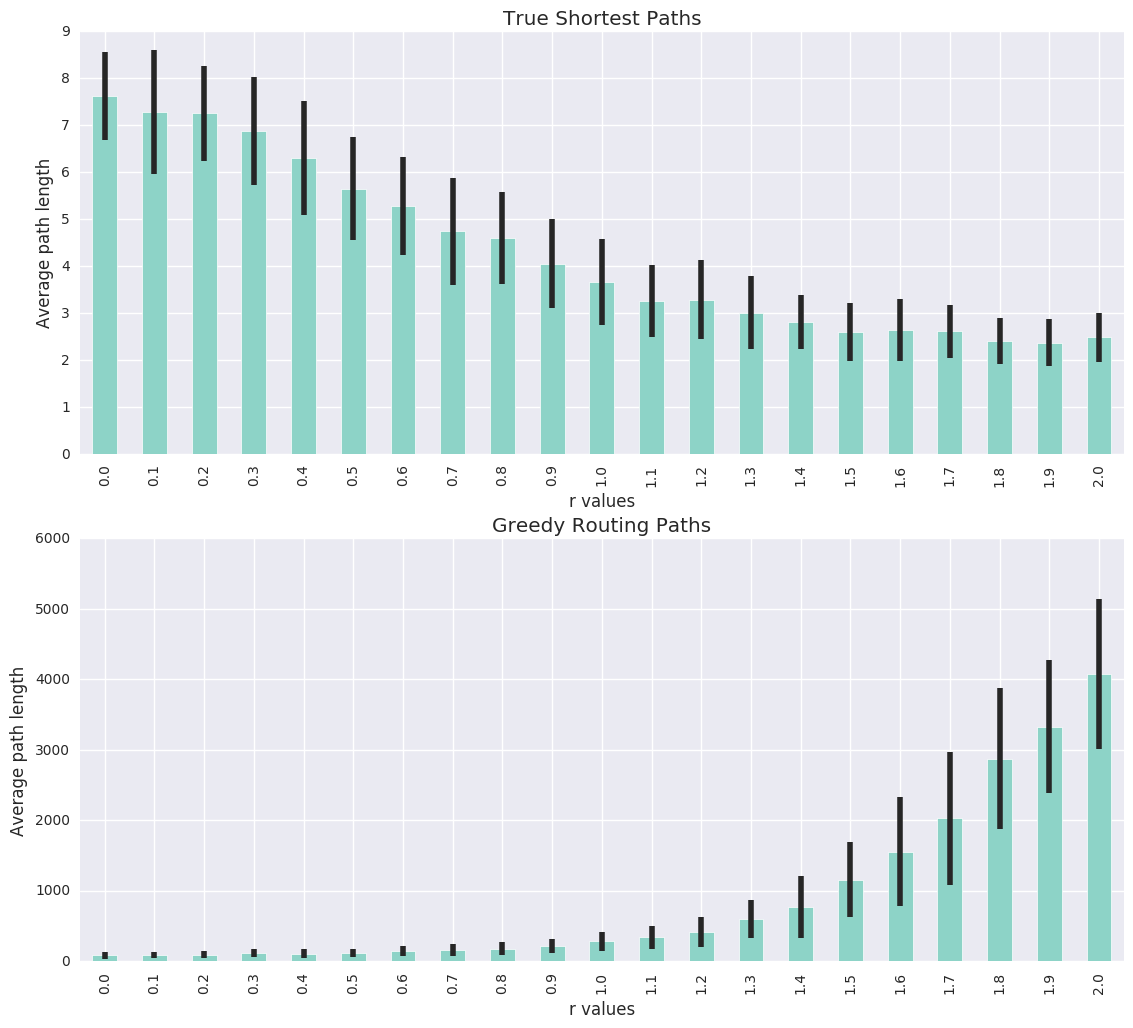

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from networkx import Graph, shortest_path_length


def dist1d(i, j, n):
    return min(abs(i - j), n - abs(i - j))
# dist1d = lambda i, j, n: min(abs(i - j), n - abs(i - j))

# def dist_to_target(x, t, n):
#     """
#     calculates the distance between several nodes to one node
#     :return: distances from nodes to target
#     """
#     x = np.asarray(x)
#     t = np.repeat(t, x.size)
#     d = np.row_stack((np.abs(x - t), n - np.abs(x - t)))
#     return np.min(d, axis=0)


def init_graph(n, r):
    graph = {i: [(i - 1) % n, (i + 1) % n] for i in range(n)}  # basic connectivity
    # long range connectivity:
    d = np.row_stack((np.arange(n), n - np.arange(n)))
    minimal_distance = np.min(d, axis=0)
    minimal_distance = minimal_distance ** -r
    minimal_distance[0] = 0     # nullify inf:  minimal_distance[~np.isfinite(minimal_distance)] = 0   
    minimal_distance /= minimal_distance.sum()
    for i in range(n):
        # following the hint: since the minimal distance values are consistent thorugh nodes,
        # we can just perform some cyclic permutation instead of re-coumputing:
        np.roll(minimal_distance, i)
        neighbour = np.where(np.random.multinomial(n=1, pvals=minimal_distance))[0][0]
        graph[i].append(neighbour)
    return graph


def calc_greedy_path_length(g, s, t):
    n = len(g.keys())
    cur_node = s
    path_length = 0
    while cur_node != t:
        d = pd.Series({x: dist1d(x, t, n) for x in g[cur_node]})
        cur_node = d.argmin()
        path_length += 1
    return path_length


plt.style.use("seaborn-darkgrid")
np.random.seed(0)            # for reproducibility
NUM_REPEATS = 100  # 100
NUM_NODES = 10000  # 10000

rs = np.arange(0, 2.1, 0.1)
source = 0
target = NUM_NODES // 2

shortest_df = pd.DataFrame(index=rs, columns=range(NUM_REPEATS))
greedy_df = pd.DataFrame(index=rs, columns=range(NUM_REPEATS))

for repeat in range(NUM_REPEATS):
    for r in rs:
        graph = init_graph(NUM_NODES, r)

        short_path_length = shortest_path_length(Graph(graph), source, target)
        shortest_df.loc[r, repeat] = short_path_length

        greedy_path_length = calc_greedy_path_length(graph, source, target)
        greedy_df.loc[r, repeat] = greedy_path_length
        

# plot:
fig, axes = plt.subplots(2,1, figsize=(12, 12), dpi=100)
shortest_df.mean(axis="columns").plot(kind="bar", yerr=shortest_df.std(axis="columns"),
                                      title="True Shortest Paths", ax=axes[0])
axes[0].set_xlabel("r values")
axes[0].set_ylabel("Average path length")

greedy_df.mean(axis="columns").plot(kind="bar", yerr=greedy_df.std(axis="columns"),
                                    title="Greedy Routing Paths", ax=axes[1])
axes[1].set_xlabel("r values")
axes[1].set_ylabel("Average path length")